## Extending the likelihood and not only using the maximum.

**Goal:** Show that bayesian linear regression is not magic.

**Usage:** 

**Dataset:** Artificial Data

**Content:**

In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow==2.0.0-alpha0  
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  False


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp

sns.reset_defaults()
#sns.set_style('whitegrid')
sns.set_context(context='talk',font_scale=0.7)

%matplotlib inline

tfd = tfp.distributions
print("TFB Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFB Version 0.7.0-dev20190511
TF  Version 2.0.0-alpha0


In [3]:
plt.style.use('default') # macht den hintergrund weg 
plt.rcParams.update({'font.size': 15}) #Macht grosse axen

In [37]:
xmin = -5;xmax = +5;ymin=-40;ymax=40;
nbins_c=30; sigma=3

In [38]:
save = True
np.random.seed(2)
num = 4
#x = np.random.normal(0,1,(num,1)) 
x = np.linspace(-2,2,num=num).reshape((num,1))
y = 2 * x[:,0] - 1 + 1.*np.random.normal(0,sigma,num) 
if save:
        d = np.transpose(np.vstack((x[:,0],y)))
        np.savetxt('nb_ch06_bayes{}.csv'.format(num), d, delimiter=',', header='x,y',comments="",fmt='%.4e'); 
        
from sklearn import linear_model
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(x,y)
# The coefficients
a_ml = regr.coef_
b_ml = regr.intercept_
print('Coefficients: \n', a_ml)
print('Coefficients: \n', b_ml)

Coefficients: 
 [2.92051026]
Coefficients: 
 -1.726712471421449


### Creation of the data set

In [39]:
fig = plt.figure(figsize=(6,6))
def createPlot(a, b):
    #num = 10 
    plt.scatter(x,y, marker='.', color='r')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.plot([xmin, xmax], [a*xmin+b, a*xmax+b], color='g', alpha = 1)
    plt.title('a = {:+.2f} b = {:+.2f}'.format(a,b))  
    plt.show()

<Figure size 432x432 with 0 Axes>

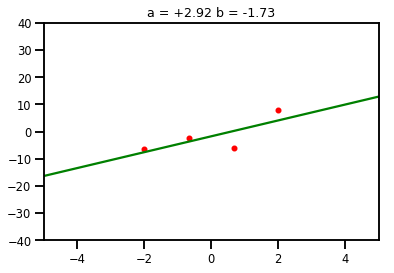

In [40]:
createPlot(a_ml[0], b_ml)

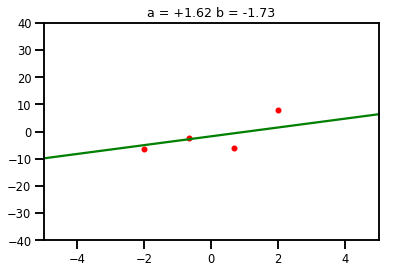

In [41]:
createPlot(a_ml[0] / 1.8, b_ml * 1)

Calculation of the predictive distribution $p(y|x,a,b)$ for a bunch of values x, and y given a fixed set of parameters.

In [42]:
def pre_distribution(a,b):
    """
        Return the predictive distribution p(y|(a,b)) for a, b
    """
    canvas0 = np.zeros((nbins_c, nbins_c), dtype=np.float32) #The complete img
    xi = np.zeros((nbins_c, nbins_c), dtype=np.float32)
    yi = np.zeros((nbins_c, nbins_c), dtype=np.float32)
    for j,x_ in enumerate(np.linspace(xmin, xmax, nbins_c)):
        py = tfd.Normal(loc=a*x_+b,scale=sigma)
        for i,y_ in enumerate(np.linspace(ymin, ymax, nbins_c)):
            xi[i,j] = x_
            yi[i,j] = y_
            #canvas0[nbins_c-i-1,j] = py.prob(y_)
            canvas0[i,j] = py.prob(y_)
    # This part is a bit tricky. The sum over y for a fixed a should be 1. 
    # However, IMHO due to (more than finite) bin width this is not the case
    # We renormalize
    return canvas0/ np.sum(canvas0,axis=0), xi, yi

Text(0.5, 1.0, 'Predictive Distribution')

<Figure size 432x432 with 0 Axes>

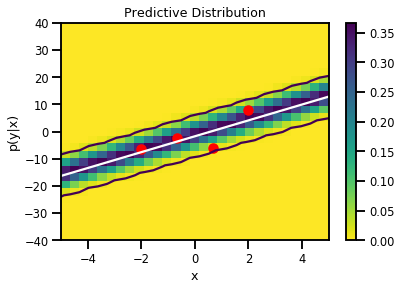

In [55]:
import scipy
s = sigma
pxy_ml,xi,yi = pre_distribution(a_ml, b_ml)
#pxy_ml,xi,yi = pre_distribution(a_ml[0] / 1.8, b_ml * 1)

fig = plt.figure(figsize=(6,6))
fig, ax0 = plt.subplots(nrows=1)
cmap = plt.get_cmap('viridis_r',)
im = plt.pcolormesh(xi, yi, pxy_ml, cmap=cmap)
plt.contour(xi, yi, pxy_ml,[scipy.stats.norm(0, s).pdf(2*s)])
fig.colorbar(im, ax=ax0)
plt.scatter(x,y, marker='o',c='r')
plt.plot([xmin, xmax], [a_ml*xmin+b_ml, a_ml*xmax+b_ml], color='w', alpha = 1)
plt.xlabel('x')
plt.ylabel('p(y|x)')
plt.title('Predictive Distribution')

In [45]:
np.sum(pxy_ml,axis=0) #

array([1.        , 0.99999994, 1.0000001 , 0.99999994, 1.        ,
       0.9999999 , 1.        , 1.        , 0.99999994, 0.99999994,
       1.0000001 , 1.        , 0.9999999 , 1.        , 0.9999999 ,
       1.0000001 , 1.        , 0.99999994, 0.99999994, 1.0000001 ,
       0.99999994, 1.0000001 , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ],
      dtype=float32)

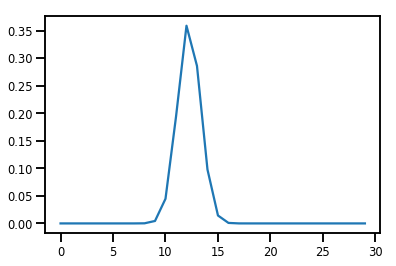

In [46]:
plt.plot(pxy_ml[:,10])

* Don't put all egg in one basket
* While it's best to use the line with the highest prob. why not also take other solutions into account?
* OK maybe not with full weight
* The more prob. they are the more we take them into account
* Idea: Sample `a` and `b` randomly (uniform). Always take the parameters with the hightest probabiliy.
    * If less then highest only take them in a certain fraction. Choose this proportional to prob.

In [47]:
ytensor = y.reshape([len(y),1])
def unnormalized_likehihood(w):
    y_prob = tfd.Independent(tfd.Normal(loc=x*w[0]+w[1], scale=sigma), reinterpreted_batch_ndims=1)
    return (tf.reduce_sum(tf.reduce_sum(y_prob.log_prob(ytensor))))

In [48]:
nbins = 10
bmin=-10;bmax=8
amin=-3;amax=8
ai, bi = np.mgrid[amin:amax:nbins*1j, bmin:bmax:nbins*1j] #wtf is j?
ws = np.vstack([ai.flatten(), bi.flatten()])
unpost = np.zeros((nbins*nbins))
for i in range((nbins*nbins)):
    unpost[i] = unnormalized_likehihood(tf.Variable([[ws[0,i]],[ws[1,i]]],dtype=tf.float32))/num
unpost = np.exp(unpost.reshape(ai.shape))
norm_like = unpost / np.sum(unpost) #<-- We normalize

Text(0.5, 1.0, 'Likelihood (normalized)')

<Figure size 432x432 with 0 Axes>

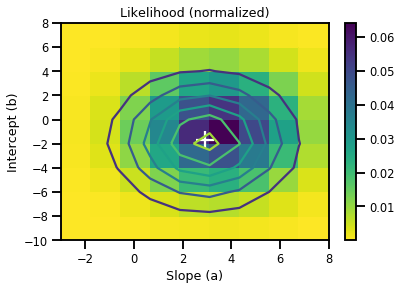

In [49]:
plt.figure(figsize=(6,6))
fig, ax0 = plt.subplots(nrows=1)
cmap = plt.get_cmap('viridis_r')
im = plt.pcolormesh(ai, bi, norm_like, shading='none',cmap=cmap)
fig.colorbar(im, ax=ax0)
plt.contour(ai, bi, norm_like)
plt.scatter(a_ml, b_ml, color='w', marker='+',s=333)
plt.xlabel('Slope (a)')
plt.ylabel('Intercept (b)')
plt.title('Likelihood (normalized)')

In [50]:
def toBin(a, amin, amax):
    a = np.clip(a, amin, amax)
    return int(0.99999*(a - amin)/(amax-amin) * nbins)

def getProb(a,b):
    return norm_like[toBin(a,amin,amax),toBin(b,bmin,bmax)]

In [51]:
getProb(a_ml,b_ml),getProb(a_ml[0] / 1.8, b_ml * 1)

(0.0641090889110285, 0.056468507279078234)

Evaluation of 
$$
    p(y|x,D) = \sum_a \sum_b p(y|x,(a,b))p((a,b)|D)
$$

In [52]:
# 10          20       30        40       50         55
#123456789012345678901234567890123456789012345678901234
pyx = np.zeros((nbins_c, nbins_c), dtype=np.float32) #A 
for a in np.linspace(amin, amax, nbins): #B
    for b in np.linspace(bmin, bmax, nbins):
        p = getProb(a,b) #C
        pyx += pre_distribution(a,b)[0] * getProb(a,b) 
        if (b == bmin):
            print(p)
#A Start with a blank canvas
#B Loop over "all" parameters a 
#C Get the probability for the parameters a and b, given the data

1.9046563846896955e-05
9.455436461028e-05
0.0003246070439147135
0.000770632589229851
0.0012651680547170765
0.0014363547735037497
0.0011276819835177212
0.0006122441356732892
0.00022986563099617718
5.9681002093201575e-05


In [2]:
plt.figure(figsize=(6,6))
fig, ax0 = plt.subplots(nrows=1)
cmap = plt.get_cmap('viridis_r',)
im = plt.pcolormesh(xi, yi, pyx, cmap=cmap)
plt.contour(xi, yi, pyx,[scipy.stats.norm(0, s).pdf(2*s)])
fig.colorbar(im, ax=ax0)
plt.scatter(x,y, marker='o',c='r')
plt.plot([xmin, xmax], [a_ml*xmin+b_ml, a_ml*xmax+b_ml], color='w', alpha = 1)
plt.xlabel('x')
plt.ylabel('p(y|x)')
plt.title('Predictive Distribution')

NameError: name 'plt' is not defined

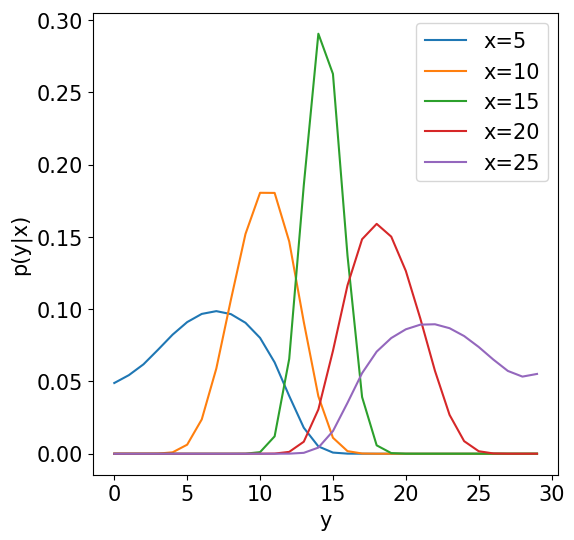

In [20]:
fig = plt.figure(figsize=(6,6))
plt.plot(pyx[:,(5,10,15,20,25)]) 
plt.xlabel('y')
plt.ylabel('p(y|x)')
plt.legend(['x=5','x=10','x=15','x=20','x=25'])

## Using Tensor Power TODO?

This could be made faster. Not 100% if necesarry